In [5]:
from text_gan.data import Squad2
from text_gan.data.qgen_data import CONFIG

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
import numpy as np
import pandas as pd
import ujson as json
from tqdm import tqdm

In [105]:
data = tfds.load("squad2", data_dir="/tf/data/tf_data", split='validation')
tokenizer = text.UnicodeScriptTokenizer()
context = data.map(lambda x: tokenizer.tokenize(x['context']), num_parallel_calls=-1)
questions = data.map(lambda x: tokenizer.tokenize(x['question']), num_parallel_calls=-1)

In [107]:
iter = data.as_numpy_iterator()
next(iter)
next(iter)
next(iter)

{'answers': {'answer_start': array([28, 28, 96, 28], dtype=int32),
  'text': array([b'Lake Constance', b'Lake Constance', b'West by the Alter Rhein',
         b'Lake Constance'], dtype=object)},
 'context': b'The mouth of the Rhine into Lake Constance forms an inland delta. The delta is delimited in the West by the Alter Rhein ("Old Rhine") and in the East by a modern canalized section. Most of the delta is a nature reserve and bird sanctuary. It includes the Austrian towns of Gai\xc3\x9fau, H\xc3\xb6chst and Fu\xc3\x9fach. The natural Rhine originally branched into at least two arms and formed small islands by precipitating sediments. In the local Alemannic dialect, the singular is pronounced "Isel" and this is also the local pronunciation of Esel ("Donkey"). Many local fields have an official name containing this element.',
 'id': b'572fe4a304bcaa1900d76e55',
 'question': b'The inland delta at the mouth of the Rhine is with what Lake?',
 'title': b'Rhine'}

In [3]:
df = pd.DataFrame({
    'clen': list(map(lambda x: len(x), context.as_numpy_iterator())),
    'qlen': list(map(lambda x: len(x), questions.as_numpy_iterator()))
})

In [4]:
df.describe(percentiles=[.5,.95])

,clen,qlen
count,130319.000000,130319.000000
mean,138.952302,11.277427
std,57.338943,3.675088
min,22.000000,1.000000
50%,128.000000,11.000000
95%,246.000000,18.000000
max,736.000000,60.000000


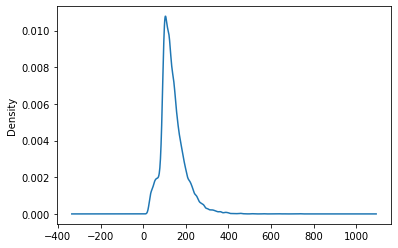

In [5]:
df.clen.plot.kde()

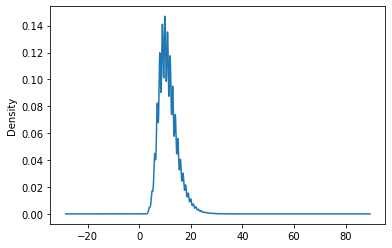

In [6]:
df.qlen.plot.kde()

In [3]:
cnumpy = list(context.as_numpy_iterator())

In [4]:
qnumpy = list(questions.as_numpy_iterator())

In [6]:
cvocab = {}

In [85]:
for c in tqdm(cnumpy):
    for i, ci in enumerate(c):
        if i >= 250:
            break
        cvocab[ci] = cvocab.get(ci, 0) + 1
len(cvocab)

100%|██████████| 130319/130319 [00:08<00:00, 16285.05it/s]


106060

In [86]:
df = pd.DataFrame({'token':list(cvocab.keys()), 'count':list(cvocab.values())})
df = df.sort_values('count', ascending=False).reset_index(drop=True)
df.shape

(106060, 2)

In [87]:
df.loc[:, 'token'] = df.token.map(lambda x: x.decode('utf-8'))
df.head()


,token,count
0,the,3153117
1,",",2447504
2,of,1828706
3,.,1730663
4,and,1477507


In [13]:
glove_embs_path = "/tf/data/squad/glove.840B.300d/glove.840B.300d.txt"
word2embs = {}
with open(glove_embs_path, "r") as f:
    line = f.readline()
    while len(line) != 0:
        word_vec = line.split(' ')
        word = word_vec[0]
        vec = np.array(word_vec[1:], dtype=np.float32)
        word2embs[word] = vec
        line = f.readline()
f"{len(word2embs)} word embeddings found"

'1669209 word embeddings found'

In [95]:
df[df['count'] > 10].shape

(100355, 2)

In [88]:
oov = 0
oov_tokens = []
for token in tqdm(df[df['count'] > 10].token):
    if token not in word2embs:
        oov += 1
        oov_tokens.append(token)
f"{oov} tokens not in glove"

100%|██████████| 100355/100355 [00:00<00:00, 1070976.27it/s]


'23669 tokens not in glove'

In [96]:
qvocab={}
for c in tqdm(qnumpy):
    for i, ci in enumerate(c):
        if i >= 20:
            break
        qvocab[ci] = qvocab.get(ci, 0) + 1
len(qvocab)


100%|██████████| 130319/130319 [00:00<00:00, 163714.64it/s]


50899

In [97]:
qdf = pd.DataFrame({'token':list(qvocab.keys()), 'count':list(qvocab.values())})
qdf = qdf.sort_values('count', ascending=False).reset_index(drop=True)
qdf.loc[:, 'token'] = qdf.token.map(lambda x: x.decode('utf-8'))
qdf

,token,count
0,?,117900
1,the,88126
2,What,59304
3,of,48790
4,in,32308
...,...,...
50894,prestiges,1
50895,istitutions,1
50896,unattractive,1
50897,immense,1


In [98]:
qdf[qdf['count'] > 20].shape

(5431, 2)

In [99]:
oov = 0
oov_tokens = []
for token in tqdm(qdf.iloc[:5000].token):
    if token not in word2embs:
        oov += 1
        oov_tokens.append(token)
f"{oov} tokens not in glove"

100%|██████████| 5000/5000 [00:00<00:00, 1019866.75it/s]


'78 tokens not in glove'